In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from utils import *

In [2]:
tools=["optitype",'T1K','hlahd',"arcas",'hisat',"rna2hla","seq2hla","phlat","hlaforest","hlavbseq",'hlaminer']
my_order=["Optitype","T1K","HLA-HD","arcasHLA","HISAT","rna2HLA","seq2HLA","PHLAT","HLAforest","HLA-vbseq",'HLAminer']

# determine accuracy

In [4]:
europe_df, yoruba_df = split_csv_by_ancestry()

data = []

for t in tools:
    
    pre=pd.read_csv("../results/standard/"+str(t)+"_d1.csv")

    europe_ret = np.sum(np.array( get_accuracy_counts(pre,europe_df) ),axis=1)

    yoruba_ret = np.sum(np.array( get_accuracy_counts(pre,yoruba_df) ),axis=1)

    data.append([t, europe_ret, yoruba_ret])

    
    
df = pd.DataFrame(data,columns=['tool','europe','yoruba'])
print(df)

         tool                europe             yoruba
0    optitype  [10, 23, 2505, 1692]  [0, 10, 392, 268]
1         T1K     [14, 67, 4149, 0]    [6, 68, 596, 0]
2       hlahd    [41, 114, 4075, 0]    [8, 72, 590, 0]
3       arcas    [36, 188, 4006, 0]    [8, 83, 579, 0]
4       hisat     [87, 89, 4054, 0]   [13, 67, 590, 0]
5     rna2hla   [119, 249, 3862, 0]   [30, 47, 593, 0]
6     seq2hla   [119, 249, 3862, 0]   [30, 47, 593, 0]
7       phlat   [413, 304, 3513, 0]  [79, 104, 487, 0]
8   hlaforest    [83, 585, 3562, 0]  [47, 137, 486, 0]
9    hlavbseq  [1863, 198, 2169, 0]  [294, 55, 319, 2]
10   hlaminer  [3142, 720, 335, 33]  [529, 87, 44, 10]


# chi square

In [9]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [10]:
# chi square test of independence

pvalues = []

for tool in data:
    etotal = sum(tool[1])
    ytotal = sum(tool[2])
    
    print(tool[0])
    
    # one field 
    obs = [ [tool[1][1]+tool[1][2],tool[1][0]] , [tool[2][1]+tool[2][2],tool[2][0]] ]
    print("\t1 field table:" , obs )

    
    res2 = chi2_contingency(obs)
    print("\t1 field p value:", res2[1])
    
    # two field 
    e2f_obs = [tool[1][2],tool[1][1]+tool[1][0]]
    y2f_obs = [tool[2][2],tool[2][1]+tool[2][0]]

    
    res4 = chi2_contingency([e2f_obs, y2f_obs])
    print("\t2 field table:" , [e2f_obs, y2f_obs])
    print("\t2 field p value:", res4[1])
    
    pvalues.append([convert_pvalue_to_asterisks(res2[1]),convert_pvalue_to_asterisks(res4[1])])
    


optitype
	1 field table: [[2528, 10], [402, 0]]
	1 field p value: 0.4238909246473468
	2 field table: [[2505, 33], [392, 10]]
	2 field p value: 0.10547584236992087
T1K
	1 field table: [[4216, 14], [664, 6]]
	1 field p value: 0.0713170921077636
	2 field table: [[4149, 81], [596, 74]]
	2 field p value: 1.872516283287006e-35
hlahd
	1 field table: [[4189, 41], [662, 8]]
	1 field p value: 0.7381378174378146
	2 field table: [[4075, 155], [590, 80]]
	2 field p value: 3.0454755940919263e-20
arcas
	1 field table: [[4194, 36], [662, 8]]
	1 field p value: 0.513129811866463
	2 field table: [[4006, 224], [579, 91]]
	2 field p value: 8.922184816486526e-16
hisat
	1 field table: [[4143, 87], [657, 13]]
	1 field p value: 0.959314422329518
	2 field table: [[4054, 176], [590, 80]]
	2 field p value: 9.207323612851953e-17
rna2hla
	1 field table: [[4111, 119], [640, 30]]
	1 field p value: 0.02710010289117268
	2 field table: [[3862, 368], [593, 77]]
	2 field p value: 0.023508278269924257
seq2hla
	1 field tabl

In [11]:
print(pvalues)

[['ns', 'ns'], ['ns', '****'], ['ns', '****'], ['ns', '****'], ['ns', '****'], ['*', '*'], ['*', '*'], ['ns', '****'], ['****', '****'], ['ns', 'ns'], ['**', 'ns']]


# plotting

In [12]:
# calculating accuracy, creating data frames
europe = np.array( df['europe'].values.tolist() )
total = np.sum(europe,axis=1)
europe_2f = (europe[:,2])/total
europe_1f = (europe[:,1]+europe[:,2])/total

yoruba = np.array( df['yoruba'].values.tolist() )
total = np.sum(yoruba,axis=1)
yoruba_2f = (yoruba[:,2])/total
yoruba_1f = (yoruba[:,1]+yoruba[:,2])/total

# concat to df
dfeuro1f = pd.DataFrame(europe_1f,columns=['europe 1-field accuracy'])
dfeuro2f = pd.DataFrame(europe_2f,columns=['europe 2-field accuracy'])
dfyoru1f = pd.DataFrame(yoruba_1f,columns=['yoruba 1-field accuracy'])
dfyoru2f = pd.DataFrame(yoruba_2f,columns=['yoruba 2-field accuracy'])

         tool                 ancestry  accuracy
0    optitype  europe 2-field accuracy  0.592199
1         T1K  europe 2-field accuracy  0.980851
2       hlahd  europe 2-field accuracy  0.963357
3       arcas  europe 2-field accuracy  0.947045
4       hisat  europe 2-field accuracy  0.958392
5     rna2hla  europe 2-field accuracy  0.913002
6     seq2hla  europe 2-field accuracy  0.913002
7       phlat  europe 2-field accuracy  0.830496
8   hlaforest  europe 2-field accuracy  0.842080
9    hlavbseq  europe 2-field accuracy  0.512766
10   hlaminer  europe 2-field accuracy  0.079196
11   optitype  yoruba 2-field accuracy  0.585075
12        T1K  yoruba 2-field accuracy  0.889552
13      hlahd  yoruba 2-field accuracy  0.880597
14      arcas  yoruba 2-field accuracy  0.864179
15      hisat  yoruba 2-field accuracy  0.880597
16    rna2hla  yoruba 2-field accuracy  0.885075
17    seq2hla  yoruba 2-field accuracy  0.885075
18      phlat  yoruba 2-field accuracy  0.726866
19  hlaforest  yorub

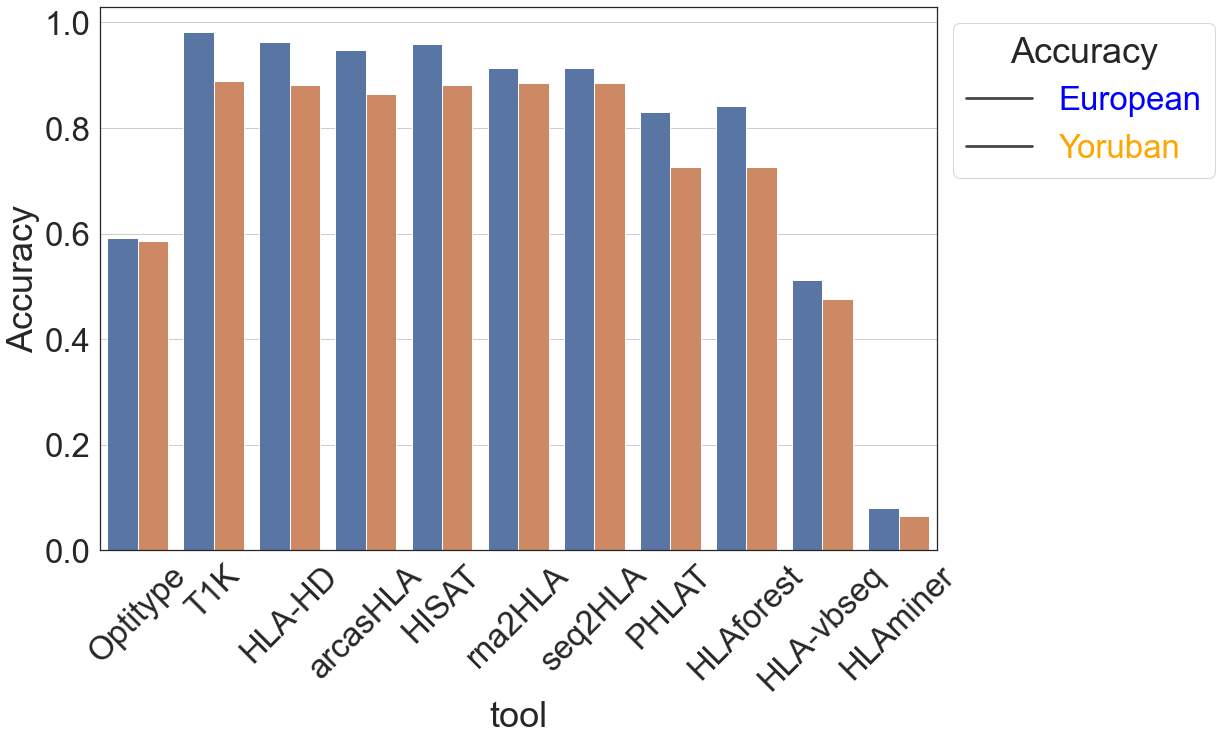

In [13]:
# 2 field accuracy

df_accuracy=pd.concat([df['tool'],dfeuro2f,dfyoru2f],axis=1, join='inner')

df_accuracy = pd.melt(df_accuracy, id_vars="tool", var_name="ancestry", value_name="accuracy")
print(df_accuracy)


sns.set_context("paper")
sns.color_palette("pastel")
sns.set(font_scale=3)
sns.set_style("white")

plt.figure(figsize=(15,10))
plt.grid()



ax=sns.barplot(x = 'tool', y = 'accuracy', data=df_accuracy,hue='ancestry',order=tools)


plt.legend(title='Accuracy', loc='upper left', labels=['European', 'Yoruban'], labelcolor=['blue','orange'],bbox_to_anchor=(1,1))

ax.set_xticklabels(labels=my_order, rotation = 45)
ax.set_ylabel("Accuracy")

plt.show()



         tool                 ancestry  accuracy
0    optitype  europe 1-field accuracy  0.597636
1         T1K  europe 1-field accuracy  0.996690
2       hlahd  europe 1-field accuracy  0.990307
3       arcas  europe 1-field accuracy  0.991489
4       hisat  europe 1-field accuracy  0.979433
5     rna2hla  europe 1-field accuracy  0.971868
6     seq2hla  europe 1-field accuracy  0.971868
7       phlat  europe 1-field accuracy  0.902364
8   hlaforest  europe 1-field accuracy  0.980378
9    hlavbseq  europe 1-field accuracy  0.559574
10   hlaminer  europe 1-field accuracy  0.249409
11   optitype  yoruba 1-field accuracy  0.600000
12        T1K  yoruba 1-field accuracy  0.991045
13      hlahd  yoruba 1-field accuracy  0.988060
14      arcas  yoruba 1-field accuracy  0.988060
15      hisat  yoruba 1-field accuracy  0.980597
16    rna2hla  yoruba 1-field accuracy  0.955224
17    seq2hla  yoruba 1-field accuracy  0.955224
18      phlat  yoruba 1-field accuracy  0.882090
19  hlaforest  yorub

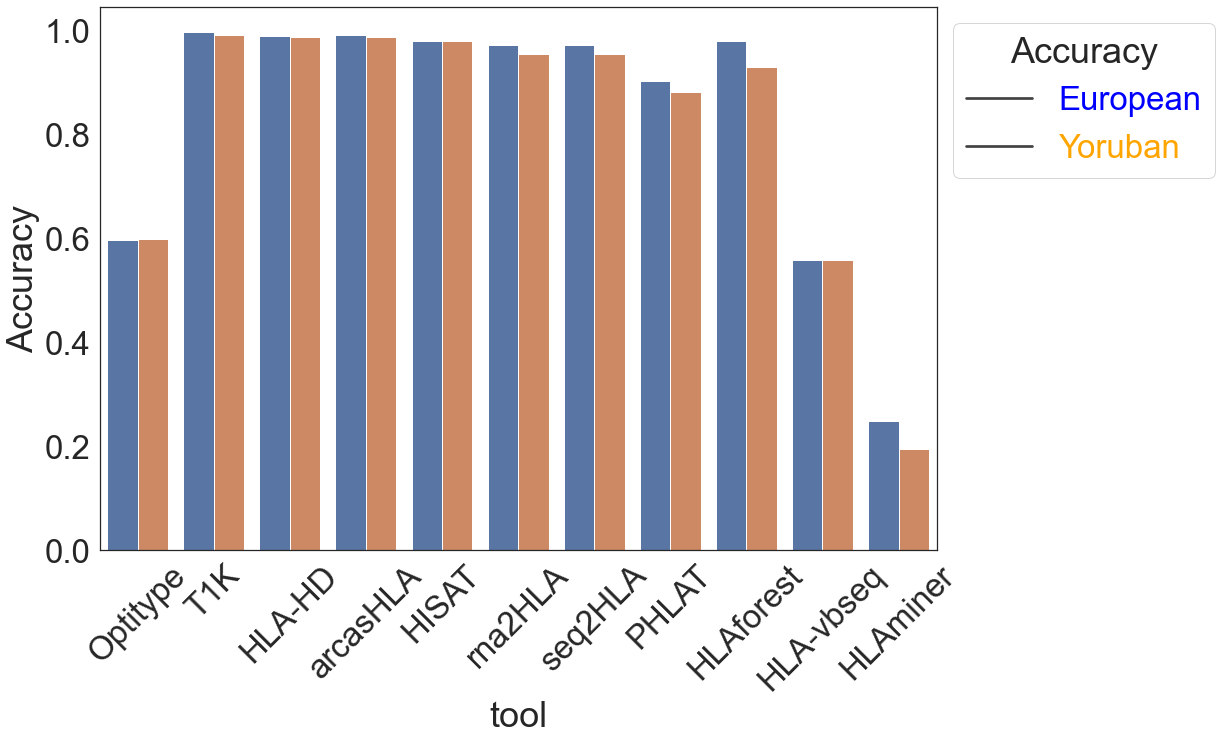

In [14]:
# 1 field accuracy plot
df_accuracy=pd.concat([df['tool'],dfeuro1f,dfyoru1f],axis=1, join='inner')
df_accuracy = pd.melt(df_accuracy, id_vars="tool", var_name="ancestry", value_name="accuracy")
print(df_accuracy)


sns.set_context("paper")
sns.color_palette("pastel")
plt.figure(figsize=(15,10))

sns.set(font_scale=3)
sns.set_style("white")

ax=sns.barplot(x = 'tool', y = 'accuracy', data=df_accuracy,hue='ancestry',order=tools)



plt.legend(title='Accuracy', loc='upper left', labels=['European', 'Yoruban'], labelcolor=['blue','orange'],bbox_to_anchor=(1,1))



ax.set_xticklabels(labels=my_order, rotation = 45)
ax.set_ylabel("Accuracy")

plt.show()
plt.show()


In [8]:
# getting 